# Ice Thickness Model

## Introduction and background information

In this assignment, you will work on modelling ice growth, based on the classical Stefan's Problem. The latter aims to determine how an ice layer grows as a function of time given the constraint that the temperature of air ($T_{air}$) is constant, smaller than the freezing temperature $T_{fr}$ and everywhere the same.

Using this problem, we can model ice growth as:

$$
H^2_{ice}-H^2_{ice,0} = \frac{2 k_{ice}}{\rho_{ice} \cdot l}\int{(T_s-T_{fr})}dt
$$

where $H_{ice}$ is the thickness of the ice at a given time $t$, $H_{ice,0}$ is the thickness of the ice at time $t=0$, $k_{ice}=2.2W/(K \cdot m)$ is the thermal conductivity of ice, $\rho_{ice}=917 kg/m^3$ is the density of ice, $l = 333.4 J/g = 333.4 kJ/kg$ is the latent heat of fusion, $T_s$ is the equal to the temperature of the air and $T_{fr}=273K$ is the freezing temperature of water.

> We want to estimate the ice thickness after 3 days, and will assume that the temperature remains stable during that period. 

Therefore, the previous equation will lead to:

$$
H_{ice} = \sqrt{\frac{2 k_{ice}}{\rho_{ice} l}\Delta T \Delta t+H^2_{ice,0}}
$$

where $\Delta T = |T_s-T_{fr}|$ and $\frac{2 k_{ice}}{\rho_{ice} l} \approx 1.44 \cdot 10^{-8} \ m^2/K s$

---
**Previous work provides the following data:**

- Based on the samples of ice measurements, the mean thickness is $\mu_{H0}=0.20m$ and the standard deviation of thickness is $\sigma_{H0}=0.03m$.

- Based on the forecast, the mean air temperature during the next 3 days is $\mu_T=263K$ and the standard deviation of the temperature of $\sigma_T=4K$.

- The rest of the variables are deterministic.

- The ice thickness and the predicted temperature are independent random variables.

**The goal of this notebook is to carry out the uncertainty propagation and validation of the propagation model. Then you will use the results to answer a few questions in the `Report.md` file.**


Note that you are interested in the increment of temperature $|T_s-T_{fr}|$, whose mean is $\mu_{iT}=|263-273|=10K$ and $\sigma_{iT}=4K$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

plt.rcParams.update({'font.size': 14})

### Internal equation check

Here we provide a simple function to check the values of ice thickness for different values of the input parameters. It may be useful to debug your code, or to get an understanding for the function of random variables.

In [2]:
def stefan(constant, H0, Ts, Tfr, time):
    return np.sqrt(constant*time*abs(Ts-Tfr) + H0**2)

In [3]:
print('Ice thickness: ' +
      f'{stefan(1.44*10**(-8), 0.15, 261, 273, 3*24*3600):.3f} m')

Ice thickness: 0.259 m


## Part 1: Transforming random variables

We start by writing all necessary functions, so we need 
1. To apply the propagation laws with `H_taylor()` to find the mean and standard deviation of the linearized function of random variables;
2. To find the distribution of `H_ice` numerically with a simulation, then compare this to the Normal distribution defined by the mean and standard deviation of the linearized function of random variables.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.1:**
    
Complete the two functions in the cell below, and support your work by including an image showing the analytic equations.
    
</p>
</div>

In [4]:
def H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT):
    """ Taylor series approximation of mean and std of H"""
    
    # # Write your own preliminary variables here
    # YOUR_CODE_HERE # Probably more than one line

    # mu_H = YOUR_CODE_HERE
    # sigma_H = YOUR_CODE_HERE

    # Solution

    constant = 1.44*10**(-8)
    time = 3*24*3600
    
    dhdiT = ((constant*time*mu_iT + mu_H0**2)**(-0.5))*constant/2*time
    dhdH0 = ((constant*time*mu_iT + mu_H0**2)**(-0.5))*mu_H0
    
    dhdiT_2 = -((constant/2*time)**2)*(constant*time*mu_iT+mu_H0**2)**(-1.5)
    dhdH0_2 = (((constant*time*mu_iT + mu_H0**2)**(-0.5)) - 
              mu_H0**2*(constant*time*mu_iT + mu_H0**2)**(-1.5))

    mu_H_0 = np.sqrt(constant*time*mu_iT + mu_H0**2)
    mu_H = mu_H_0 + 0.5*dhdiT_2*sigma_iT**2 + 0.5*dhdH0_2*sigma_H0**2
    var_H = (dhdiT**2)*sigma_iT**2 + (dhdH0**2)*sigma_H0**2
    sigma_H = np.sqrt(var_H)
    
    return mu_H, sigma_H

def samples_plot(N, mu_H0, mu_iT, sigma_H0, sigma_iT):
    """Generate samples and plots for V
    
    Compares the approximated Normal distribution of V to numerically
    approximated distribution, found by sampling from the input
    distributions.
    
    Return: a plot and the mean and std dev of simulated values of H_ice.
    """
    # H0_samples = YOUR_CODE_HERE
    # iT_samples = YOUR_CODE_HERE

    # Solution
    H0_samples = np.random.normal(mu_H0, sigma_H0, N)
    iT_samples = np.random.normal(mu_iT, sigma_iT, N)

    # negative values of ice thickness not physically possible
    count_negative_iT = sum(iT_samples < 0)
    if count_negative_iT > 0:
        iT_samples[iT_samples < 0] = 0
        print(f'Number of iT samples adjusted to 0: {count_negative_iT} '+
              f'({count_negative_iT/N*100:.1f}% of N)')
    
    # h_samples = YOUR_CODE_HERE
    # mu_H = YOUR_CODE_HERE
    # sigma_H = YOUR_CODE_HERE

    # Solution
    constant = 1.44*10**(-8)
    time = 3*24*3600
    h_samples = np.sqrt(constant*time*iT_samples + H0_samples**2)
    mu_H = np.mean(h_samples)
    sigma_H = np.std(h_samples)
    
    # Plot histogram
    xmin = 0.0
    xmax = 0.5
    x = np.linspace(xmin, xmax, 100)
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))

    # ax[0].hist(YOUR_CODE_HERE,
    #            bins = 40, density = True,
    #            edgecolor='black', linewidth=1.2, 
    #            label = 'Empirical PDF of ${H_{ice}}$')

    # Solution
    ax[0].hist(h_samples,
               bins = 40, density = True,
               edgecolor='black', linewidth=1.2, 
               label = 'Empirical PDF of ${H_{ice}}$')
    
    # Add normal pdf in same figure
    # ax[0].plot(x, YOUR_CODE_HERE, color = 'black',
    #            lw = 2.5, label='Normal PDF')

    # Solution
    mu_H_taylor, sigma_H_taylor = H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT)
    ax[0].plot(x, norm.pdf(x, mu_H_taylor, sigma_H_taylor), color = 'black',
               lw = 2.5, label='Normal PDF')
    ax[0].set_xlim(xmin, xmax)
    ax[0].legend()
    ax[0].set_xlabel('${H_{ice} [m]}$')
    ax[0].set_ylabel('Density')
    ax[0].set_title(f'Simulation with {N} simulated realizations'
                    + '\n' + f'mean = {mu_H:.3e}' 
                    f'm and std = {sigma_H:.3e} m')
    
    # Add probability plot in right-side panel
    # probplot(YOUR_CODE_HERE, dist = norm, fit = True, plot = ax[1])
    
    # Solution
    probplot(h_samples, dist = norm, fit = True, plot = ax[1])
    ax[1].legend(['Generated samples', 'Normal fit'])
    ax[1].get_lines()[1].set_linewidth(2.5)
    plt.show()
    
    return mu_H, sigma_H, h_samples

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution 1.1:**

See solution in the previous code.

</p>
</div>

## Part 2: Mean and Variance propagation laws

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 2.1:**
    
Use the functions defined in Task 1 to compute the mean and standard deviation of the linearized function of random variables, and compare the distribution defined by this result to the distribution of $H_{ice}$ found using simulation.
    
</p>
</div>

Now we can compute the mean $\mu_H$ and standard deviation $\sigma_H$ as function of:  
- $\mu_T = 10 \; \mathrm{K}$ and $\sigma_T = 4 \; \mathrm{K}$
- $\mu_{H_0} = 0.20 \; \mathrm{m}$ and $\sigma_{H_0} = 0.03 \; \mathrm{m}$

Comparison of propagated and simulated distributions:

Number of iT samples adjusted to 0: 55 (0.5% of N)


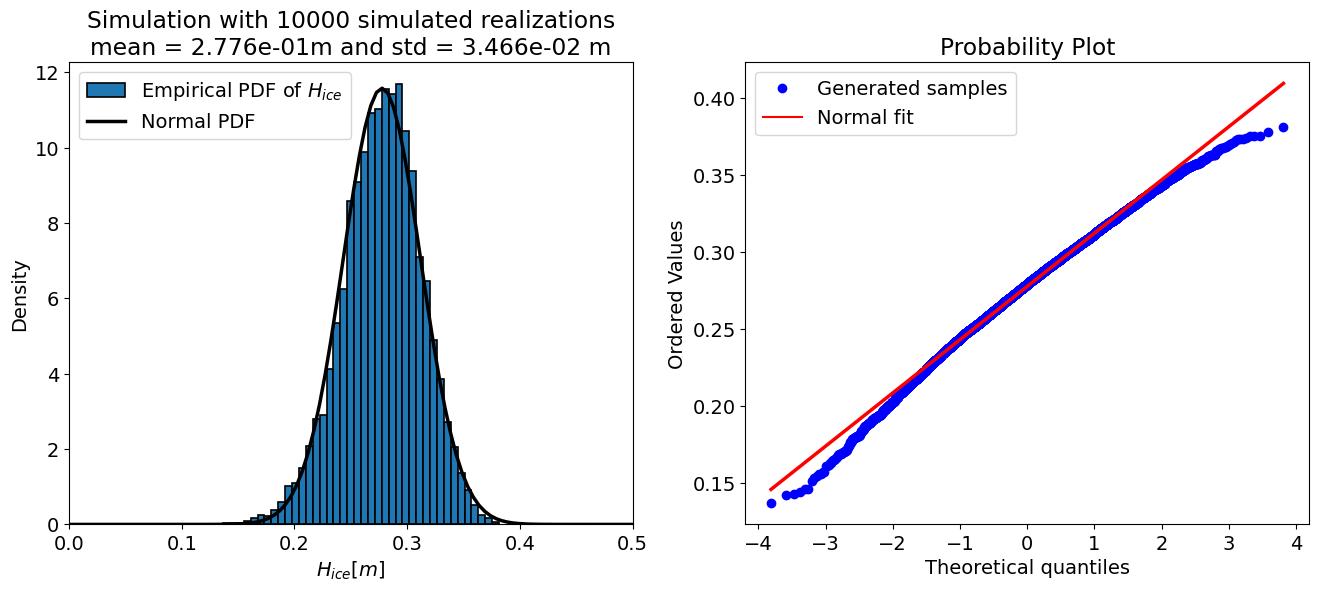



Mean and standard deviation of linearized function:
  μ ₕ= 0.278 m
  σ ₕ= 0.034 m


Mean and standard deviation of simulated distribution:
  μ ₕ = 0.278 m
  σ ₕ= 0.035 m




In [5]:
mu_iT = 10
sigma_iT = 4
mu_H0 = 0.20
sigma_H0 = 0.03
N = 10000

# mu_H, sigma_H = YOUR_CODE_HERE

# Solution
mu_H, sigma_H = H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT)

print('Comparison of propagated and simulated distributions:\n')
mu_H_simulated, sigma_H_simulated, _ = samples_plot(N,
                                                    mu_H0, mu_iT,
                                                    sigma_H0, sigma_iT)

print('\n\nMean and standard deviation of linearized function:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{mu_H:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H:.3f}', 'm')

print('\n\nMean and standard deviation of simulated distribution:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H} =',
      f'{mu_H_simulated:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H_simulated:.3f}', 'm')
print('\n')

**NOTE** Recall that the right-hand plot above (and below) is by default labeled "theoretical quantiles" but in fact it is the q value (see description in WS 1.2). The y-axis contains the ordered values of the output variable, ice thickness.

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution 2.1:**

See solution in the previous code.

</p>
</div>

## Part 3: Monte Carlo simulations - sample size

As you may recall, the "accuracy" of a Monte Carlo simulation depends on the size of the sample. The code cell below sets up a loop and prints the output of the uncertainty propagation for a few different sample sizes. Take a look at the results and see how they change.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.1:**
    
The code cell below can be used for your answer to one of the questions in the Report, where you are asked to consider the "inaccurate" values that might be produced by this model.
    
</p>
</div>

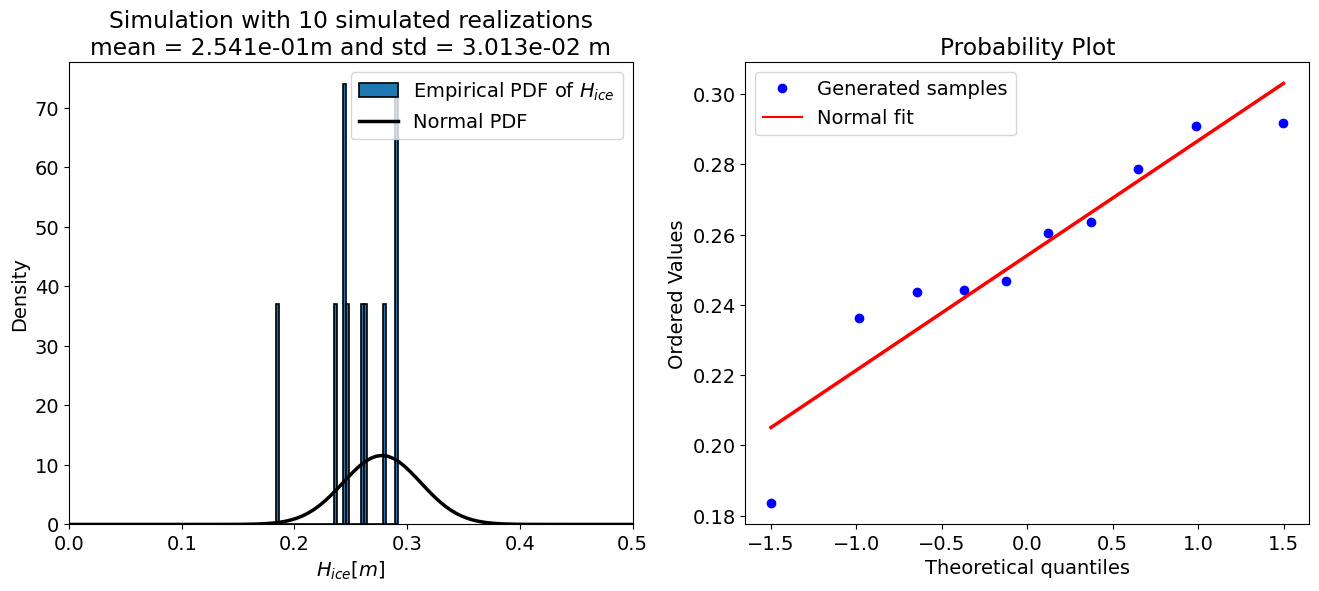

For N = 10 samples:
    mean = 0.254 m
    std = 0.030 m

Number of iT samples adjusted to 0: 1 (1.0% of N)


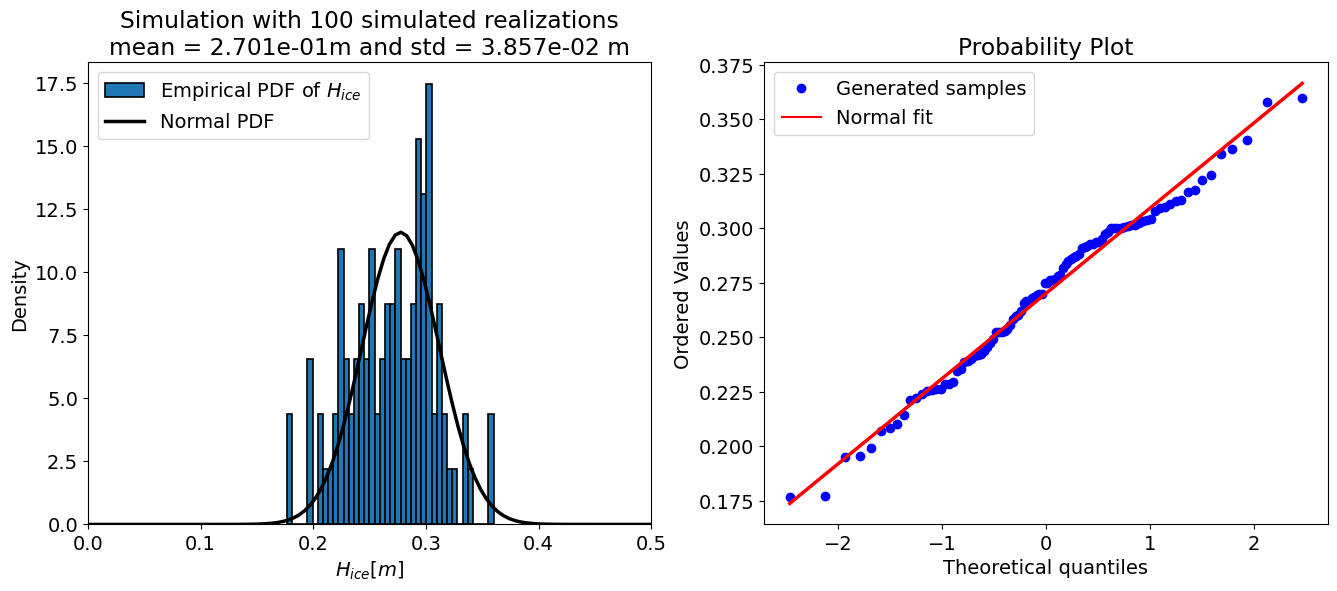

For N = 100 samples:
    mean = 0.270 m
    std = 0.039 m

Number of iT samples adjusted to 0: 62 (0.6% of N)


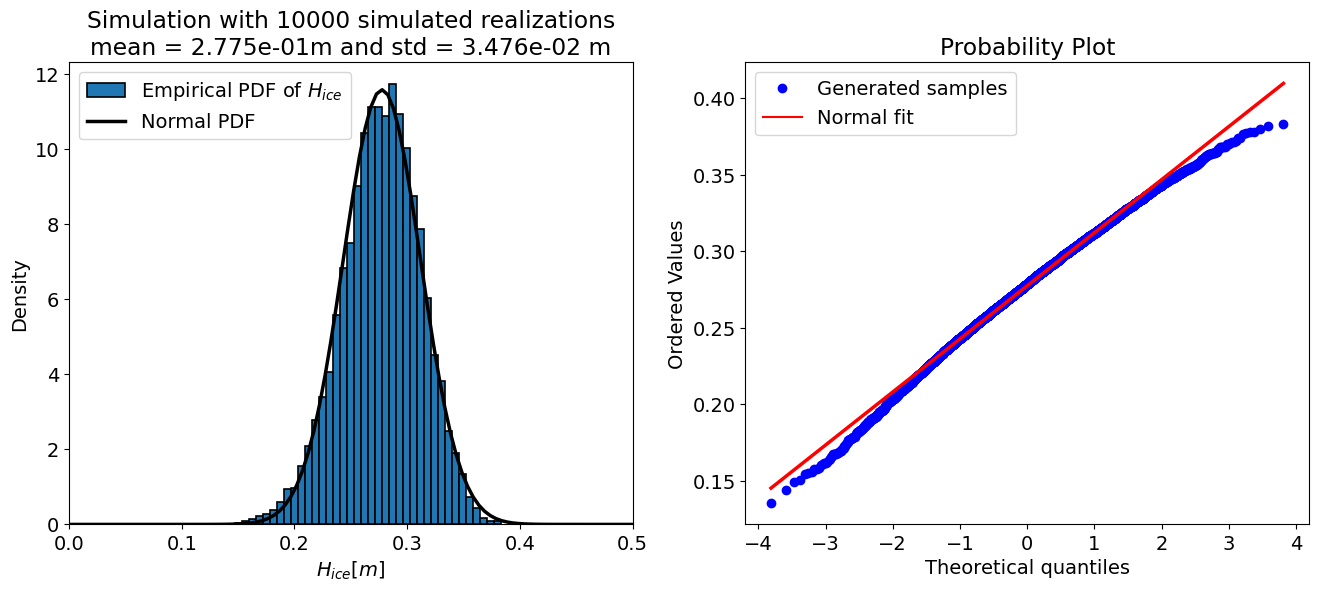

For N = 10000 samples:
    mean = 0.278 m
    std = 0.035 m

Number of iT samples adjusted to 0: 598 (0.6% of N)


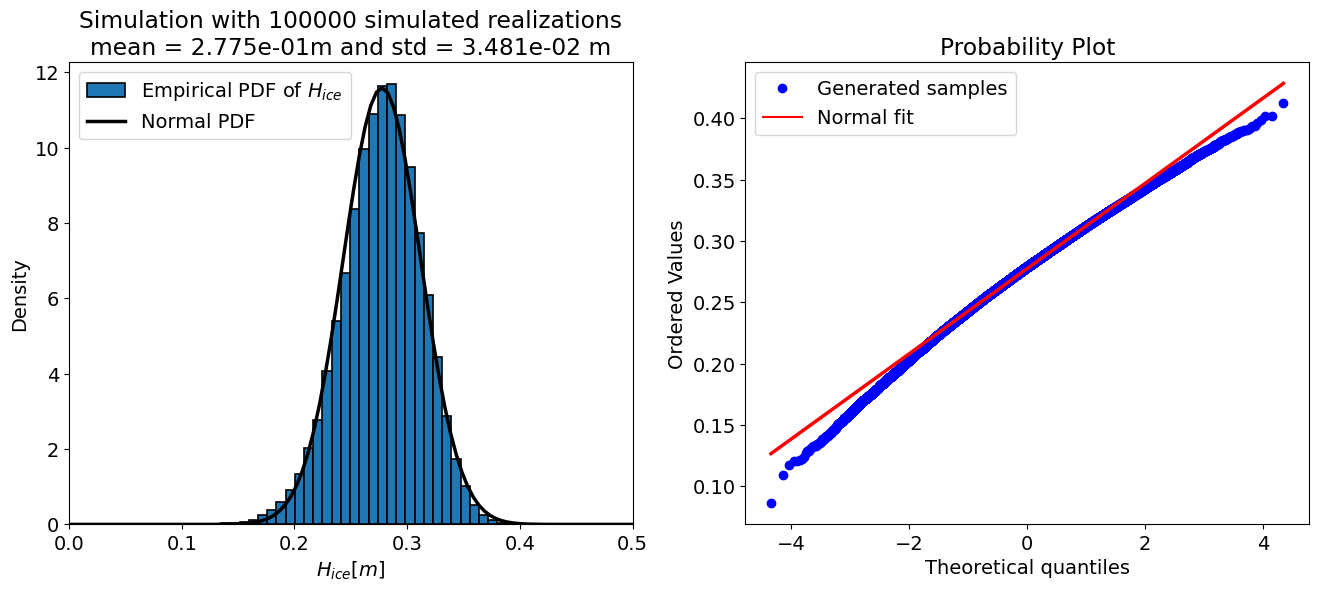

For N = 100000 samples:
    mean = 0.278 m
    std = 0.035 m



In [6]:
for N in [10, 100, 10000, 100000]:
    mu_H_simulated, sigma_H_simulated, h_samp = samples_plot(N,
                                                             mu_H0,
                                                             mu_iT,
                                                             sigma_H0,
                                                             sigma_iT)
    print(f'For N = {N} samples:')
    print(f'    mean = {mu_H_simulated:.3f} m')
    print(f'    std = {sigma_H_simulated:.3f} m\n')

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution 3.1:**

Solution in the code.

</p>
</div>

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.2:**
    
The code cell below can be used for your answer to one of the questions in the Report, where you are asked to consider the "inaccurate" values that might be produced by this model.
    
</p>
</div>

In [7]:
# YOUR_CODE_HERE

for i in np.linspace(0.1, 0.4, 10):
    print(f'for an ice thickness of {i:5.2f} m --> ' +
          f'{100*sum(h_samp <= i)/len(h_samp):8.4f}% of samples, ' +
          f'{100*norm.cdf(i, mu_H, sigma_H):8.4f}% of distribution')

for an ice thickness of  0.10 m -->   0.0010% of samples,   0.0000% of distribution
for an ice thickness of  0.13 m -->   0.0180% of samples,   0.0014% of distribution
for an ice thickness of  0.17 m -->   0.2180% of samples,   0.0642% of distribution
for an ice thickness of  0.20 m -->   1.9230% of samples,   1.2165% of distribution
for an ice thickness of  0.23 m -->  10.4650% of samples,   9.9560% of distribution
for an ice thickness of  0.27 m -->  36.1950% of samples,  37.5909% of distribution
for an ice thickness of  0.30 m -->  73.6090% of samples,  74.2661% of distribution
for an ice thickness of  0.33 m -->  95.3960% of samples,  94.7318% of distribution
for an ice thickness of  0.37 m -->  99.7270% of samples,  99.5162% of distribution
for an ice thickness of  0.40 m -->  99.9970% of samples,  99.9811% of distribution


<div style="background-color:#F6C78B; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

Once you have completed the analysis in this notebook, proceed to the questions in `Report.md`
    
</p>
</div>

> By Lotfi Massarweh, Delft University of Technology. CC BY 4.0, more info on the Credits page of Workbook. 